## Multivariable time series forecasting using the `linear-tree`
**Author: [Carl McBride Ellis](https://www.kaggle.com/carlmcbrideellis)** ([LinkedIn](https://www.linkedin.com/in/carl-mcbride-ellis/))

Time series forecasting is perhaps one of the most economically important applications of machine learning, reflected by the abundance of packages to deal with this problem. However, forecasting is extremely difficult, in part  due to [concept drift](https://en.wikipedia.org/wiki/Concept_drift), an example of which would be covariate shift where the distribution of the test data (including the targets) differs from that of the training data. Such covariate shifts are frequently encountered in time series forecasting problems.

Traditional "statistical" approaches to time series include [ARIMA](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html) and [SARIMAX](https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html).
Another very popular technique, harnessing the power of neural networks, is the LSTM estimator, for example see the notebook [LSTM time series prediction: sine wave example](https://www.kaggle.com/code/carlmcbrideellis/lstm-time-series-prediction-sine-wave-example/notebook). Yet another promising approach is [incremental learning](https://en.wikipedia.org/wiki/Incremental_learning) (also known as *stream learning* or *online learning*) where the estimator is periodically retrained on any new data that becomes available. For further reading see the references section at the end of this notebook.

It is covariate shift that causes particular problems for tree based estimators and their extensions, such as Random Forest, XGBoost, *etc*. as these estimators are unable to extrapolate. Here we shall look at a technique that combines the power of non-parametric tree based estimators with the extrapolation ability of linear regression, which is available in the  [`linear-tree`](https://github.com/cerlymarco/linear-tree) package written by [Marco Cerliani](https://github.com/cerlymarco).

For this exercise we shall be using a simple synthetic dataset, and then we shall make use of the multivariable data associated with the ["Smart Home's Temperature - Time Series Forecasting"](https://www.kaggle.com/competitions/smart-homes-temperature-time-series-forecasting) competition, which was very kindly organized by [Abir ELTAIEF](https://www.kaggle.com/abireltaief).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 16})

!pip install -q ptitprince
import ptitprince as pt

## Example using synthetic data

A standard assumption for most machine learning algorithms to work well is that both the training and the test datasets constitute samples drawn form the same distribution, these are often known as *independent and identically distributed* (IID) samples. However, when we have covariate shifts this is no longer the case (a clever trick often seen on kaggle to test this IID assumption is known as [adversarial validation](https://www.kaggle.com/code/carlmcbrideellis/what-is-adversarial-validation/notebook)).

It is also known that decision trees and their ensemble variants such as the [Random Forest](https://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm), and gradient boosting frameworks such as  [XGBoost](https://xgboost.readthedocs.io/en/latest/), [LightGBM](https://www.microsoft.com/en-us/research/project/lightgbm/),  [CatBoost](https://catboost.ai/) *etc*. cannot extrapolate, as we can see in the graphic below (adapted from the notebook ["Extrapolation: Do not stray out of the forest!"](https://www.kaggle.com/code/carlmcbrideellis/extrapolation-do-not-stray-out-of-the-forest)). 

![](https://raw.githubusercontent.com/Carl-McBride-Ellis/images_for_kaggle/main/XGBoost_vs_Linear_tree.png)

What does this imply for time series forecasting? 

First we shall create some artificial temperature data; the training data will represent the winter, and the test data will represent the summer, where (almost by definition) the temperature is higher than in the winter. For the purposes of this demonstration these will simply be sine waves. We shall then  fit this data with the scikit-learn [HistGradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html) (we would obtain very similar results with  XGBoost, LightGMB or CatBoost). We shall then use a hybrid [linear-tree](https://github.com/cerlymarco/linear-tree) regressor.

In [2]:
n_hours = 24
n_days  = 3

one = np.ones(n_hours)
two = one*2
three = one*3
day_of_year = np.append(one, [two, three])

time_of_day = np.tile(np.arange(n_hours),n_days)
temperature = 1 * np.sin(time_of_day* (2*np.pi/n_hours))

train = pd.DataFrame(day_of_year, columns = ['day_of_year'])
train['time_of_day'] = time_of_day.tolist()
train['tmp'] = temperature.tolist()
train['temperature'] = temperature.tolist()

four = one*4
five = one*5
six  = one*6
day_of_year = np.append(four, [five, six])

test = pd.DataFrame(day_of_year, columns = ['day_of_year'])
test['time_of_day'] = time_of_day.tolist()
test['tmp'] = (temperature + 1.25).tolist()
test['temperature'] = (temperature + 1.25).tolist()
test.index = np.arange(len(train), len(train)+len(test))

X_train = train.iloc[:,[0,2]]
y_train = train["temperature"]
X_test = test.iloc[:,[0,2]]

In [5]:
X_train

,day_of_year,tmp
0,1.0,0.000000
1,1.0,0.258819
2,1.0,0.500000
3,1.0,0.707107
4,1.0,0.866025
...,...,...
67,3.0,-0.965926
68,3.0,-0.866025
69,3.0,-0.707107
70,3.0,-0.500000


Here are the results for the `HistGradientBoostingRegressor`

In [6]:
from sklearn.ensemble import HistGradientBoostingRegressor

regressor = HistGradientBoostingRegressor(min_samples_leaf=1)
regressor.fit(X_train, y_train)
test["predictions"] = regressor.predict(X_test)

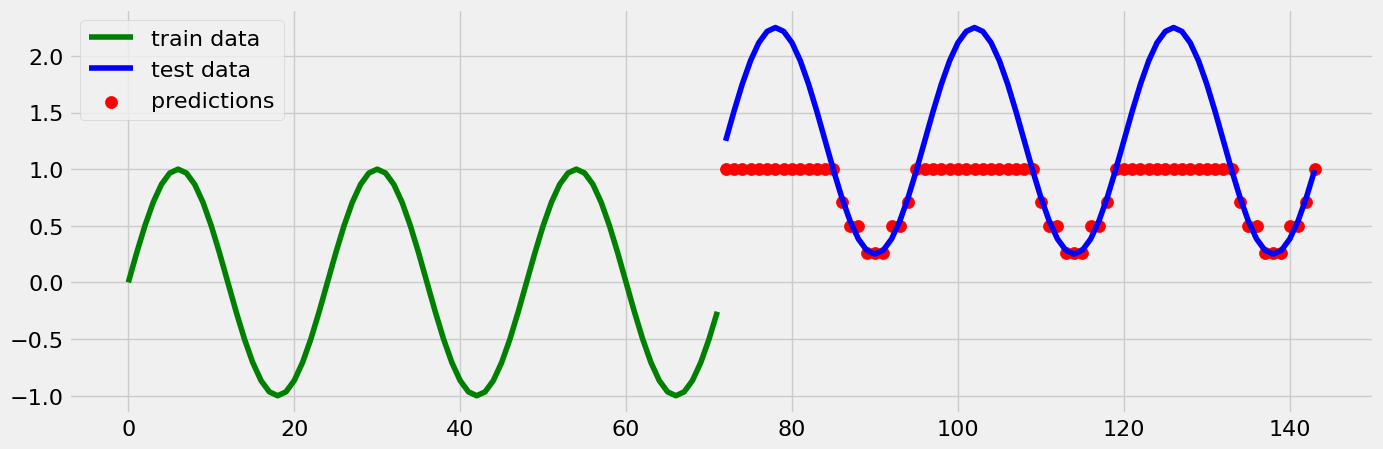

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(train.index,train["temperature"], label='train data', color="green")
ax.plot(test.index,test["temperature"], label='test data', color="blue")
#ax.plot(test.index, test["predictions"],  label='predictions', color="red")
ax.scatter(test.index, test["predictions"], label='predictions', color="red", s=75)
ax.legend(loc="upper left")
plt.show();

we can see that it does a good job for the region corresponding to previously seen target ranges, but is incapable of returning any target values that lie outside of the range of the target values it was originally trained on, thus when the summer temperatures rise above those seen in the winter we get the [clipping](https://en.wikipedia.org/wiki/Clipping_%28audio%29) seen above. Because of this, the application of standard decision trees or their extensions can lead to very poor results.

In [8]:
from sklearn.metrics import mean_squared_error
print('MSE = %.4g' % mean_squared_error(test["temperature"],test["predictions"]))

MSE = 0.4436


For example, in the ["Smart Home's competition"](https://www.kaggle.com/competitions/smart-homes-temperature-time-series-forecasting) the training data the target `Indoor_temperature_room`  has maximum and minimum values of 25 and 11 degrees respectively. This means that with any decision tree based estimator, regardless of the values of the input features, a prediction outside of that range will never be returned. If the test data targets differ from those seen during training, again we shall obtain sub-optimal  results.

### Now for the Linear Tree
Ideally we would like to combine the power of the non-parametric decision tree estimators with the ability to extrapolate that is inherent in linear regression.  To do this we shall use the [linear-tree](https://github.com/cerlymarco/linear-tree) package written by [Marco Cerliani](https://github.com/cerlymarco). We shall use the very same training data as in the previous example

In [9]:
#!pip install -q --upgrade linear-tree

from lineartree           import LinearBoostRegressor
from sklearn.linear_model import LinearRegression

In [10]:
regressor = LinearBoostRegressor(base_estimator=LinearRegression(),
                                 n_estimators = 300,
                                 max_depth    = 5,
                                 random_state = 42)
regressor.fit(X_train, y_train)
test["predictions"] = regressor.predict(X_test)

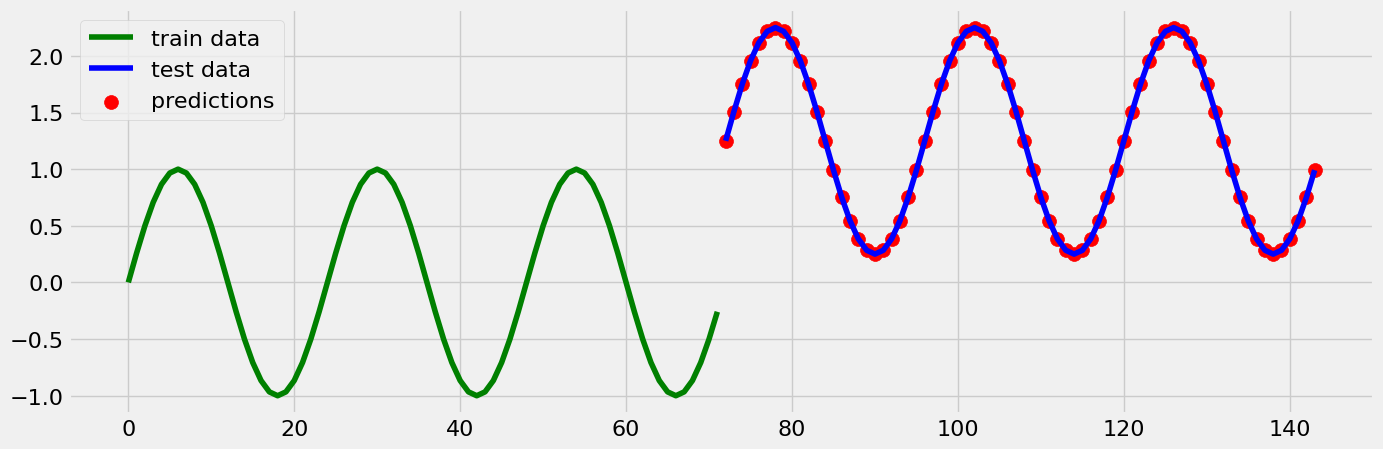

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(train.index,train["temperature"], label='train data', color="green")
ax.plot(test.index,test["temperature"], label='test data', color="blue")
ax.scatter(test.index, test["predictions"], label='predictions', color="red", s=100)
ax.legend(loc="upper left")
plt.show();

We can see that the results are now far more encouraging: we can now produce valid predictions outside of the original range of the training data targets.

In [12]:
print('MSE = %.4g' % mean_squared_error(test["temperature"],test["predictions"]))

MSE = 1.572e-11


## Smart Home's Temperature competition data
For a more practical example let us now apply the linear tree estimator to the Smart Home's Temperature competition data.
### read in the competition datasets

In [13]:
train_data_all = pd.read_csv("../input/smart-homes-temperature-time-series-forecasting/train.csv")
test_data      = pd.read_csv("../input/smart-homes-temperature-time-series-forecasting/test.csv")

FileNotFoundError: [Errno 2] No such file or directory: '../input/smart-homes-temperature-time-series-forecasting/train.csv'

set up some temporal features, here representing the day of the year, and the time of day in minutes

In [14]:
for df in (train_data_all, test_data):
    # create a day of the year feature
    df['Date'] = pd.to_datetime(df['Date'])
    df['day_of_the_year'] = df['Date'].dt.dayofyear.astype(float)
    # create a minute of the day feature
    time = pd.DatetimeIndex(df['Time'])
    df["minute_of_day"] = (time.hour * 60 + time.minute).astype(float)

NameError: name 'train_data_all' is not defined

### data cleaning
We shall remove the days 73, 80 and 309 from the training data

In [ ]:
train_data = train_data_all[(train_data_all.day_of_the_year != 73)
                          & (train_data_all.day_of_the_year != 80)
                          & (train_data_all.day_of_the_year != 309)].copy()

### feature engineering and selection
Here we shall create some new features that are related to the CO<sub>2</sub> data, such as the average value of the CO<sub>2</sub>, and the value of this average having a lag of one hour, and also the daily mean of this average:

In [ ]:
for df in (train_data, test_data):
    df["CO2_avg"] = (df["CO2_(dinning-room)"] + df["CO2_room"])/2
    df["CO2_avg_and_shift"] = df["CO2_avg"].shift(4).bfill()
    df['CO2_avg_mean'] = df.groupby('day_of_the_year')['CO2_avg'].transform('mean')

Suffice to say that experimenting with [creating features such as these can often lead to huge improvements in model performance](https://www.kaggle.com/code/ryanholbrook/time-series-as-features).

(*Caveat emptor*: It is worth being aware that the `CO2_avg_mean` feature that is being used actually constitutes a form of [data leakage](https://en.wikipedia.org/wiki/Leakage_%28machine_learning%29) known as [look-ahead bias](https://www.investopedia.com/terms/l/lookaheadbias.asp); to know the 
value of this feature, one has to know *a priori* the values for the whole day *before* forecasting, so if one is being strict then this feature should really not be used if one is not forecasting complete days at a time).


In [ ]:
features_to_keep = train_data.columns[3:].tolist()

# remove target
features_to_keep.remove('Indoor_temperature_room')

# remove not very useful features
features_to_keep.remove('Day_of_the_week')

In [ ]:
X_train = train_data[features_to_keep]
y_train = train_data["Indoor_temperature_room"]
X_test  = test_data[features_to_keep]

### fit and predict

In [ ]:
regressor.fit(X_train, y_train)
# write the predictions to the test dataframe
test_data["predictions"] = regressor.predict(X_test)

## Results
Finally, let us visually compare the distribution of the temperatures in the training data with the distribution of 
our predicted temperatures as a [Raincloud plot](https://www.kaggle.com/code/carlmcbrideellis/box-strip-violin-raincloud-plot), using the [PtitPrince](https://github.com/pog87/PtitPrince) package

In [ ]:
mono_font = {'fontname':'monospace'}
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
pt.RainCloud(data=train_data, y="Indoor_temperature_room", bw=0.1, cut=0, hue=['teal'], orient='h', label="training data", palette=['teal'], alpha = .65)
pt.RainCloud(data=test_data, y="predictions", bw=0.1, cut=0, orient='h',label="predictions", hue=['crimson'], palette=['crimson'], alpha = .65)
plt.title("Indoor_temperature_room", fontsize=18, **mono_font)
plt.xlabel("Temperature")
legend = plt.legend()
plt.tick_params(labelleft=False, left=False)
plt.show()

In [ ]:
# create a submission.csv file
sample = pd.read_csv("../input/smart-homes-temperature-time-series-forecasting/sample_submission.csv")
sample["Indoor_temperature_room"] = test_data['predictions']
sample.to_csv('submission.csv',index=False)

which results in a MSE of **2.91** for the Public Leaderboard dataset. In comparison, the very same process using the `HistGradientBoostingRegressor` returns a Public Leaderboard MSE of **6.84**. 

(Note that post-processing by way of smoothing out our predictions using a [rolling average](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html) will result in a better Leaderboard score, but our primary focus here is to illustrate the performance of the `LinearBoostRegressor`).

## <center style="background-color:Gainsboro; width:60%;">Conclusion</center>

Although the linear tree is not at all expected to outperform the more sophisticated deep learning approaches, it can certainly serve as a sanity check for  results obtained using other methods, it can also be used for rapid experimentation and prototyping; exploring feature engineering, post-processing ideas *etc*. before investing in  more computationally intensive solutions.
 
## <center style="background-color:Gainsboro; width:60%;">Related material</center>


**Linear trees**
* [linear-tree](https://github.com/cerlymarco/linear-tree) - GitHub package written by [Marco Cerliani](https://github.com/cerlymarco)
* [Haozhe Zhang, Dan Nettleton, Zhengyuan Zhu "*Regression-Enhanced Random Forests*", arXiv 1904.10416 (2019)](https://arxiv.org/pdf/1904.10416.pdf)
* [Igor Ilic, Berk Gorgulu, Mucahit Cevik, Mustafa Gokce Baydogan "*Explainable boosted linear regression for time series forecasting*", arXiv 2009.09110
(2020)](https://arxiv.org/pdf/2009.09110.pdf)

**Neural networks**
* [STAM (SpatioTemporal Attention) Model Implementation](https://www.kaggle.com/code/abireltaief/stam-spatiotemporal-attention-model-implementation) written by  [Abir ELTAIEF](https://www.kaggle.com/abireltaief).
* [Adapted Google WaveNet-Time Series Forecasting](https://www.kaggle.com/code/abireltaief/adapted-google-wavenet-time-series-forecasting) written  by [Abir ELTAIEF](https://www.kaggle.com/abireltaief).
* [LSTM time series prediction: sine wave example](https://www.kaggle.com/code/carlmcbrideellis/lstm-time-series-prediction-sine-wave-example/notebook)
* [Temporal Convolutional Network using Keras-TCN](https://www.kaggle.com/code/carlmcbrideellis/temporal-convolutional-network-using-keras-tcn/notebook)


**Incremental learning**
* [River](https://riverml.xyz/latest/) - a python package for online/streaming machine learning
* [Vowpal Wabbit](https://vowpalwabbit.org/docs/vowpal_wabbit/python/latest/index.html) - Vowpal Wabbit is a fast machine learning library for online learning
* [scikit-multiflow](https://scikit-multiflow.github.io/) - (now part of River)

### <center style="background-color:Gainsboro; width:60%;">Interesting reading</center>
* [Rob J. Hyndman and George Athanasopoulos "*Forecasting: Principles and Practice*", (3rd Edition)](https://otexts.com/fpp3/)
* [Fotios Petropoulos, *et al. "Forecasting: Theory and Practice*", arXiv:2012.03854 (2020)](https://arxiv.org/pdf/2012.03854.pdf)
* [Hansika Hewamalage, *et al. "Forecast Evaluation for Data Scientists: Common Pitfalls and Best Practices*", arXiv:2203.10716 (2022)](https://arxiv.org/pdf/2203.10716.pdf)